In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
%matplotlib inline

In [6]:
# for image quality metrices
from skimage.measure import compare_ssim as ssim

In [7]:
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [45]:

def prepare_images(path,factor):
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)
        
#help(cv2.resize)        
    

In [97]:
prepare_images('source/',2)

Saving baba_mom.jpg
Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving batman.jpg
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving girl.jpg
Saving hajurba.jpg
Saving head_GT.bmp
Saving lenna.bmp
Saving me.jpg
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving raj.jpg
Saving sponge.jpg
Saving woman_GT.bmp
Saving zebra.bmp


In [63]:
# TESTING THE GENETATED IMAGES USING IMAGE QUALTIY METRICES

In [90]:
for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

C:\Users\1CYNOSA1\Anaconda3\envs\tensor_gpu\lib\site-packages\ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


baba_mom.jpg
PSNR: 33.430009326389566
MSE: 88.552470703125
SSIM: 0.9423284440391674

baboon.bmp
PSNR: 20.051808002302312
MSE: 1927.6173
SSIM: 0.5006928299822372

baby_GT.bmp
PSNR: 31.69723520103162
MSE: 131.97087478637695
SSIM: 0.8883361032967249

barbara.bmp
PSNR: 23.447393065729266
MSE: 881.9872540509259
SSIM: 0.73065294994638

batman.jpg
PSNR: 26.323165525694563
MSE: 454.8676625
SSIM: 0.8809158381779566

bird_GT.bmp
PSNR: 29.79135363470666
MSE: 204.6756847993827
SSIM: 0.9128571831791062

butterfly_GT.bmp
PSNR: 22.006520728495104
MSE: 1228.9933776855469
SSIM: 0.797964951530857

coastguard.bmp
PSNR: 24.189445957446942
MSE: 743.4589942392677
SSIM: 0.6096745582108661

comic.bmp
PSNR: 21.16826542909264
MSE: 1490.6479002770084
SSIM: 0.7093499981550738

face.bmp
PSNR: 28.747257347129583
MSE: 260.3010265700483
SSIM: 0.7185510464651969

flowers.bmp
PSNR: 24.88592275321631
MSE: 633.2997845303868
SSIM: 0.7894223069949616

foreman.bmp
PSNR: 27.103603466719377
MSE: 380.05046559343435
SSIM: 0.886

In [61]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [50]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [51]:
def predict(image_path):
    
    
    SRCNN=model()
    # load the srcnn model with weights
    SRCNN.load_weights('weights.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = SRCNN.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

C:\Users\1CYNOSA1\Anaconda3\envs\tensor_gpu\lib\site-packages\ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 32.9717779215716
MSE: 98.40650856389986
SSIM: 0.9532838164378017

Reconstructed Image: 
PSNR: 36.54718663485879
MSE: 43.1999209486166
SSIM: 0.9693544478647688



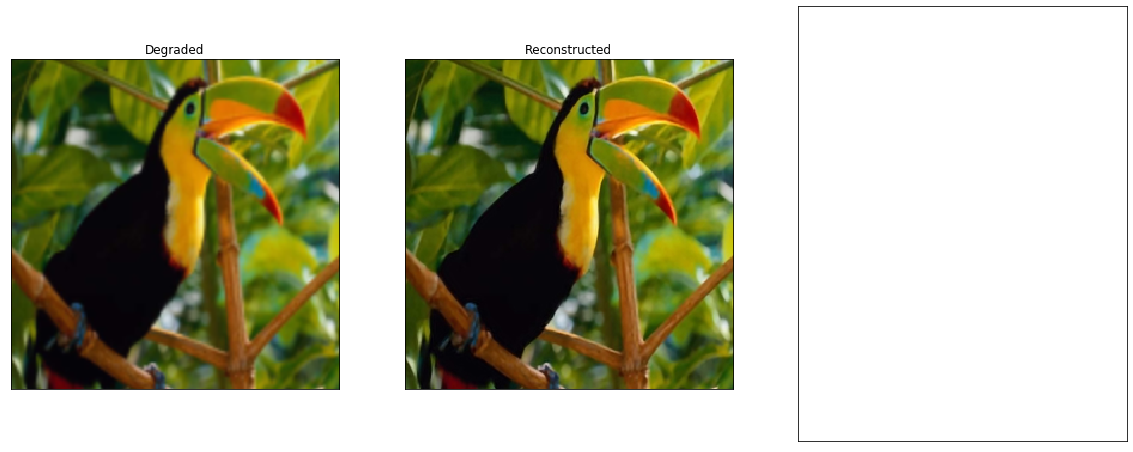

In [98]:
ref, degraded, output, scores = predict('images/bird_GT.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
#axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
#axs[0].set_title('Original')
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[0].set_title('Degraded')
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1].set_title('Reconstructed')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
